In [1]:
import argparse
import tensorflow as tf

from tuner import HyperparameterTuner

from tensorflow.contrib import tpu
from tensorflow.contrib.cluster_resolver import TPUClusterResolver

In [2]:
hidden_layers = 2
hidden_units = 500
num_perms = 2
trials = 10
epochs = 10
task_home = 'gs://continual_learning/permMNIST_EWC/'
checkpoint_path = task_home + 'logs/checkpoints/'
summaries_path = task_home + 'logs/summaries/'
data_path = task_home + 'MNIST_data/'
tpu_name = 'gectpu'

In [3]:
tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
sess = tf.Session(tpu_cluster)
sess.run(tpu.initialize_system())

b'\n\x03\x02\x02\x02\x10\x01\x18\x08"\x18\x00\x00\x00\x00\x00\x01\x00\x01\x00\x00\x01\x01\x01\x00\x00\x01\x00\x01\x01\x01\x00\x01\x01\x01'

In [4]:
tuner = HyperparameterTuner(sess=sess, hidden_layers=hidden_layers, hidden_units=hidden_units,
                                        num_perms=num_perms, trials=trials, epochs=epochs,
                                        checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                                        data_path=data_path)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting gs://continual_learning/permMNIST_EWC/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting gs://continual_learning/permMNIST_EWC/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting gs://continual_learning/permMNIST_EWC/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting gs://continual_learning/permMNIST_EWC/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.

In [5]:
from queue import PriorityQueue

In [6]:
# task 0
t = 0
queue = PriorityQueue()
for learning_rate in tuner.trial_learning_rates:
    tuner.train_on_task(t, learning_rate, queue)
tuner.best_parameters.append(queue.get())

training layers=2,hidden=500,lr=0.00094,multiplier=1067.63,mbsize=250,epochs=10,perm=0 with weights initialized at None
saving model layers=2,hidden=500,lr=0.00094,multiplier=1067.63,mbsize=250,epochs=10,perm=0 at time step 1119
finished training layers=2,hidden=500,lr=0.00094,multiplier=1067.63,mbsize=250,epochs=10,perm=0
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/logs/checkpoints/layers=2,hidden=500,lr=0.00094,multiplier=1067.63,mbsize=250,epochs=10,perm=0.ckpt-1119
training layers=2,hidden=500,lr=0.00038,multiplier=2599.17,mbsize=250,epochs=10,perm=0 with weights initialized at None
saving model layers=2,hidden=500,lr=0.00038,multiplier=2599.17,mbsize=250,epochs=10,perm=0 at time step 1119
finished training layers=2,hidden=500,lr=0.00038,multiplier=2599.17,mbsize=250,epochs=10,perm=0
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/logs/checkpoints/layers=2,hidden=500,lr=0.00038,multiplier=2599.17,mbsize=250,epochs=

In [7]:
# accuracy on validation sets
print("task0", tuner.classifier.test(sess=tuner.sess, model_name=tuner.file_name(tuner.trial_learning_rates[0], 0), batch_xs=tuner.task_list[0].validation.images, batch_ys=tuner.task_list[0].validation.labels))
print("task1", tuner.classifier.test(sess=tuner.sess, model_name=tuner.file_name(tuner.trial_learning_rates[0], 0), batch_xs=tuner.task_list[1].validation.images, batch_ys=tuner.task_list[1].validation.labels))

INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/logs/checkpoints/layers=2,hidden=500,lr=0.00094,multiplier=1067.63,mbsize=250,epochs=10,perm=0.ckpt-1119
task0 0.9917905
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/logs/checkpoints/layers=2,hidden=500,lr=0.00094,multiplier=1067.63,mbsize=250,epochs=10,perm=0.ckpt-1119
task1 0.0


In [9]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
# task1
t = 1
lr = 0.00094
# 1e19 works good - [62, 72] for 15000
#1e22 - [69, 68] for 15000
fisher_multiplier = 1e24
model_name = tuner.file_name(lr, t)
dataset_train = tuner.task_list[t].train
dataset_lagged = tuner.task_list[t - 1].train if t > 0 else None
model_init_name = tuner.best_parameters[t - 1][1] if t > 0 else None
MINI_BATCH_SIZE = 250
LOG_FREQUENCY = 100
dataset_train.initialize_iterator(MINI_BATCH_SIZE)
if (dataset_lagged is not None):
    dataset_lagged.initialize_iterator(MINI_BATCH_SIZE)

In [72]:
tuner.classifier.prepare_for_training(sess=tuner.sess, 
                                    model_name=model_name, 
                                    model_init_name=model_init_name, 
                                    fisher_multiplier=fisher_multiplier, 
                                    learning_rate=lr)

INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/logs/checkpoints/layers=2,hidden=500,lr=0.00094,multiplier=1067.63,mbsize=250,epochs=10,perm=0.ckpt-1119


In [73]:
eval_frequency = 100
num_updates = 15000

In [74]:
all_accuracies = []
for i in range(num_updates):
    tuner.classifier.minibatch_sgd(tuner.sess, i, dataset_train, MINI_BATCH_SIZE, LOG_FREQUENCY)
    if (i % eval_frequency == 0):
        accuracies = []
        for j in range(num_perms):
            val_data = tuner.task_list[j].validation
            feed_dict = tuner.classifier.create_feed_dict(val_data.images, val_data.labels, keep_input=1.0, keep_hidden=1.0)
            accuracy = sess.run(tuner.classifier.accuracy, feed_dict=feed_dict)
            accuracies.append(accuracy)
        all_accuracies.append(accuracies)

In [75]:
print(all_accuracies)

[[0.9906177, 0.0], [0.9917905, 0.0], [0.9917905, 0.0], [0.9917905, 0.0], [0.9917905, 0.0], [0.9917905, 0.0], [0.9917905, 0.0], [0.9917905, 0.0], [0.9913995, 0.0024570024], [0.98944485, 0.023341523], [0.9851446, 0.04340704], [0.98319, 0.06306306], [0.9792807, 0.074529074], [0.9784988, 0.08763309], [0.9784988, 0.097870596], [0.97888976, 0.10401311], [0.97810787, 0.11629812], [0.9784988, 0.124078624], [0.97810787, 0.13513513], [0.977717, 0.14250614], [0.97537136, 0.15069614], [0.971853, 0.17321867], [0.97068024, 0.18714169], [0.96716183, 0.20966421], [0.9636435, 0.21867321], [0.9628616, 0.22563472], [0.96207976, 0.23587224], [0.94839716, 0.27231777], [0.94370604, 0.3018018], [0.94175136, 0.32186732], [0.9366693, 0.33742833], [0.92963254, 0.35913187], [0.92337763, 0.37100738], [0.9171228, 0.38411137], [0.9143862, 0.3976249], [0.90813136, 0.41482392], [0.90304923, 0.43079442], [0.90304923, 0.43816543], [0.8995309, 0.45085996], [0.8901486, 0.46068797], [0.88623923, 0.46232596], [0.8835027, 0

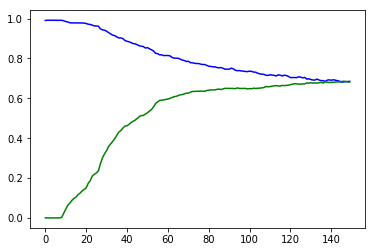

In [76]:
all_accuracies_plot = np.array(all_accuracies)
plt.plot(all_accuracies_plot[:, 0], color='b')
plt.plot(all_accuracies_plot[:, 1], color='g')
plt.show()


In [6]:
sess.run(tpu.shutdown_system())

NotFoundError: Container tpu_worker does not exist.
	 [[Node: ShutdownDistributedTPU_1 = _ShutdownDistributedTPU[_device="/job:tpu_worker/replica:0/task:0/device:TPU_SYSTEM:0"](^disconnect_tpu_host/_1)]]

Caused by op 'ShutdownDistributedTPU_1', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2907, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-2bdc1a343162>", line 1, in <module>
    sess.run(tpu.shutdown_system())
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/tensorflow/contrib/tpu/python/tpu/tpu.py", line 98, in shutdown_system
    shutdown_distributed_tpu = tpu_ops.shutdown_distributed_tpu()
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/tensorflow/contrib/tpu/ops/gen_tpu_ops.py", line 790, in shutdown_distributed_tpu
    "ShutdownDistributedTPU", name=name)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/home/sbshriram16/tf_venv/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Container tpu_worker does not exist.
	 [[Node: ShutdownDistributedTPU_1 = _ShutdownDistributedTPU[_device="/job:tpu_worker/replica:0/task:0/device:TPU_SYSTEM:0"](^disconnect_tpu_host/_1)]]
